# Assignment 2 for 論理生命学

#### Setup & Dependencies

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

np.random.seed(0)

#### Load and display all images

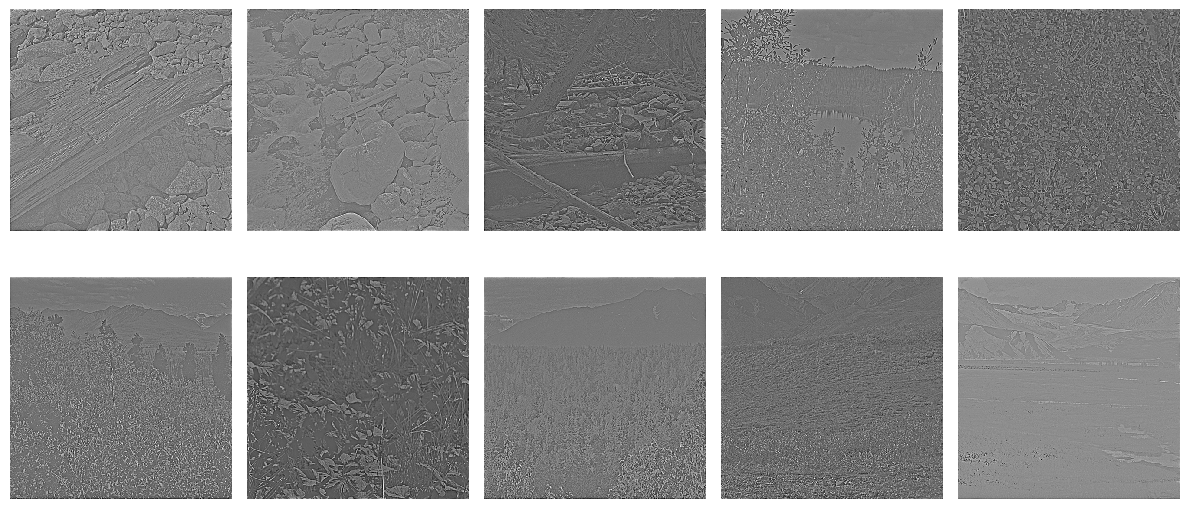

In [2]:
mat = scipy.io.loadmat('IMAGES.mat')
images = mat['IMAGES']

n_images = images.shape[2]
cols = 5
rows = (n_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
for idx, ax in enumerate(axes.flat):
    if idx < n_images:
        ax.imshow(images[:, :, idx], cmap='gray', interpolation='nearest')
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Extract and display patch

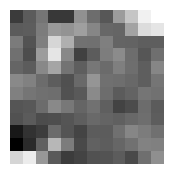

In [3]:
def extract_random_patch(images, patch_size=12, num_images=5):
    H, W, N = images.shape
    
    idx5 = np.random.choice(N, size=num_images, replace=False)
    img_idx = np.random.choice(idx5)
    i = np.random.randint(0, H - patch_size + 1)
    j = np.random.randint(0, W - patch_size + 1)
    patch = images[i:i+patch_size, j:j+patch_size, img_idx]
    
    return patch

# Extract and display a single patch
patch = extract_random_patch(images)
plt.figure(figsize=(2, 2))
plt.imshow(patch, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

#### Initialize model parameters

In [4]:
def init_model(num_bases=100, patch_dim=12):
    D = patch_dim * patch_dim
    W = np.random.randn(D, num_bases)
    lambda_ = np.ones(num_bases)
    return W, lambda_

W, lambda_ = init_model()

#### E-step

In [ ]:
def e_step(Y, W, lambda_, sigma2=1.0, n_iters=3):
    K = W.shape[1]
    x = np.zeros(K)
    for _ in range(n_iters):
        grad = (W.T @ (Y - W @ x)) / sigma2 - lambda_ * x
        H = - (W.T @ W) / sigma2 - np.diag(lambda_)
        dx = np.linalg.solve(H, grad)
        x -= dx
        S = -np.linalg.inv(H)
        lambda_ = 1.0 / (x**2 + np.diag(S))
    return x, lambda_, S

#### M-step

In [6]:
def m_step(W, Y, x, lr=0.01):
    grad_W = np.outer(Y - W @ x, x)
    W += lr * grad_W
    W /= np.linalg.norm(W, axis=0)
    return W

#### Training loop

In [7]:
n_iters = 20000
for it in range(n_iters):
    # Sample and preprocess one patch
    Y = extract_random_patch(images)
    Y = Y.flatten().astype(float)
    Y -= Y.mean()
    Y /= Y.std()
    
    # E-step
    x, lambda_, _ = e_step(Y, W, lambda_)
    
    # M-step
    W = m_step(W, Y, x, lr=0.01)
    
    # Optional progress indicator
    if (it + 1) % 2500 == 0:
        print(f"Iteration {it+1}/{n_iters} completed")

Iteration 2500/20000 completed
Iteration 5000/20000 completed
Iteration 7500/20000 completed
Iteration 10000/20000 completed
Iteration 12500/20000 completed
Iteration 15000/20000 completed
Iteration 17500/20000 completed
Iteration 20000/20000 completed


#### Plot

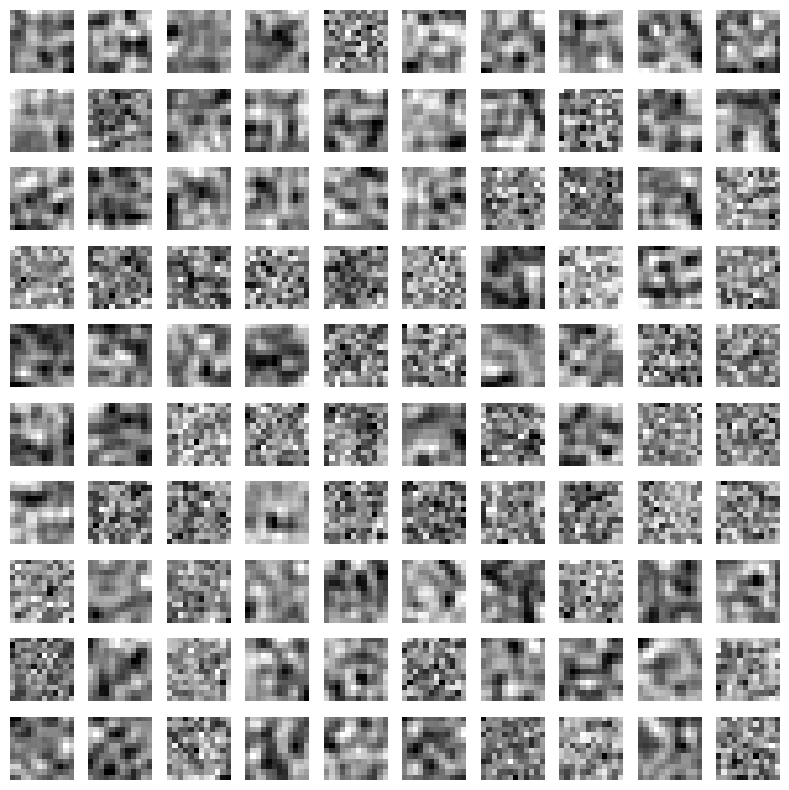

In [8]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
for k, ax in enumerate(axes.flat):
    basis = W[:, k].reshape(12, 12)
    ax.imshow(basis, cmap='gray', interpolation='nearest')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tqdm import tqdm

data = loadmat('IMAGES.mat')
images = data['IMAGES']
np.random.seed(0)


def extract_random_patches(images, patch_size=(12, 12), num_patches=5):
    patches = []
    img_height, img_width, num_images = images.shape
    for _ in range(num_patches):
        img_idx = np.random.randint(num_images)
        i = np.random.randint(img_height - patch_size[0] + 1)
        j = np.random.randint(img_width - patch_size[1] + 1)
        patch = images[i:i+patch_size[0], j:j+patch_size[1], img_idx]
        patches.append(patch)
    return np.array(patches)

def extract_random_patch_from_image1(images, patch_size=(12, 12)):
    img_idx = np.random.randint(images.shape[2])
    i = np.random.randint(images.shape[0] - patch_size[0] + 1)
    j = np.random.randint(images.shape[1] - patch_size[1] + 1)
    patch = images[i:i+patch_size[0], j:j+patch_size[1], img_idx]
    return patch

def e_step(x, lamb, lamb_mat, Y):
    DlogpxY = np.dot(psi.T, (Y - np.dot(psi, x))) - np.dot(lamb_mat,x)
    DDlogpxY = -np.dot(psi.T, psi) - np.diag(lamb)
    x += np.dot(np.linalg.inv(-DDlogpxY), DlogpxY)
    W = -np.linalg.inv(DDlogpxY)
    x_map = np.dot(np.linalg.inv(np.dot(psi.T, psi) + np.diag(lamb)), np.dot(psi.T, Y))
    lamb = 1 / np.diag(W + np.outer(x_map, x_map))
    lamb_mat = np.diag(lamb)
    return x, x_map, lamb, lamb_mat, W

def m_step(x_map, Y, W, psi):
    psi += 0.01 * (np.outer(Y,x_map) - np.dot(psi,(W + np.outer(x_map,x_map))))
    psi = psi / np.linalg.norm(psi, axis=0)
    return psi


fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[:, :, i], cmap='gray', interpolation='nearest')
    ax.axis('off')
plt.savefig('results/all_images.png')
plt.clf()

patches = extract_random_patches(images)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(patches[i], cmap='gray', interpolation='nearest')
    ax.axis('off')
plt.savefig('results/random_patches.png')
plt.clf()

echos = 20000
psi = np.random.randn(144, 100)
for i in tqdm(range(echos)):
    x_map=None
    x = np.zeros(100)
    lamb = np.ones(100)
    lamb_mat=np.diag(lamb)
    Y = extract_random_patch_from_image1(images)
    Y = Y.flatten()
    Y = (Y - np.mean(Y)) / np.std(Y)
    for j in range(3):
        x, x_map, lamb, lamb_mat, W = e_step(x, lamb, lamb_mat, Y)
    psi = m_step(x_map, Y, W, psi)
    

plt.figure(figsize=(10, 6))
for i in range(psi.shape[1]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(psi[:, i].reshape((12, 12)), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.savefig('results/final_results(echos={},learning coeff={}).png'.format(echos, 0.01))
plt.clf()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tqdm import tqdm

# 设置随机种子
np.random.seed(0)

In [6]:
# 加载数据
data = loadmat('IMAGES.mat')
images = data['IMAGES']

def extract_random_patches(images, patch_size=(12, 12), num_patches=5):
    """提取多个随机补丁"""
    patches = []
    img_height, img_width, num_images = images.shape
    for _ in range(num_patches):
        img_idx = np.random.randint(num_images)
        i = np.random.randint(img_height - patch_size[0] + 1)
        j = np.random.randint(img_width - patch_size[1] + 1)
        patch = images[i:i+patch_size[0], j:j+patch_size[1], img_idx]
        patches.append(patch)
    return np.array(patches)

def extract_random_patch_from_image1(images, patch_size=(12, 12)):
    """从图像中提取单个随机补丁"""
    img_idx = np.random.randint(images.shape[2])
    i = np.random.randint(images.shape[0] - patch_size[0] + 1)
    j = np.random.randint(images.shape[1] - patch_size[1] + 1)
    patch = images[i:i+patch_size[0], j:j+patch_size[1], img_idx]
    return patch

In [7]:
def e_step(x, lamb, lamb_mat, Y, psi):
    """E-step: 使用MAP估计"""
    # 计算梯度 (一阶导数)
    gradient = np.dot(psi.T, (Y - np.dot(psi, x))) - np.dot(lamb_mat, x)
    # 计算Hessian矩阵 (二阶导数)
    hessian = -np.dot(psi.T, psi) - np.diag(lamb)
    # 牛顿法更新
    x += np.dot(np.linalg.inv(-hessian), gradient)
    # 计算协方差矩阵
    covariance = -np.linalg.inv(hessian)
    # MAP估计
    x_map = np.dot(np.linalg.inv(np.dot(psi.T, psi) + np.diag(lamb)), np.dot(psi.T, Y))
    # 更新稀疏性参数
    lamb = 1 / np.diag(covariance + np.outer(x_map, x_map))
    lamb_mat = np.diag(lamb)
    return x, x_map, lamb, lamb_mat, covariance

def m_step(x_map, Y, covariance, psi):
    """M-step: 更新字典矩阵"""
    psi += 0.01 * (np.outer(Y, x_map) - np.dot(psi, (covariance + np.outer(x_map, x_map))))
    psi = psi / np.linalg.norm(psi, axis=0)
    return psi

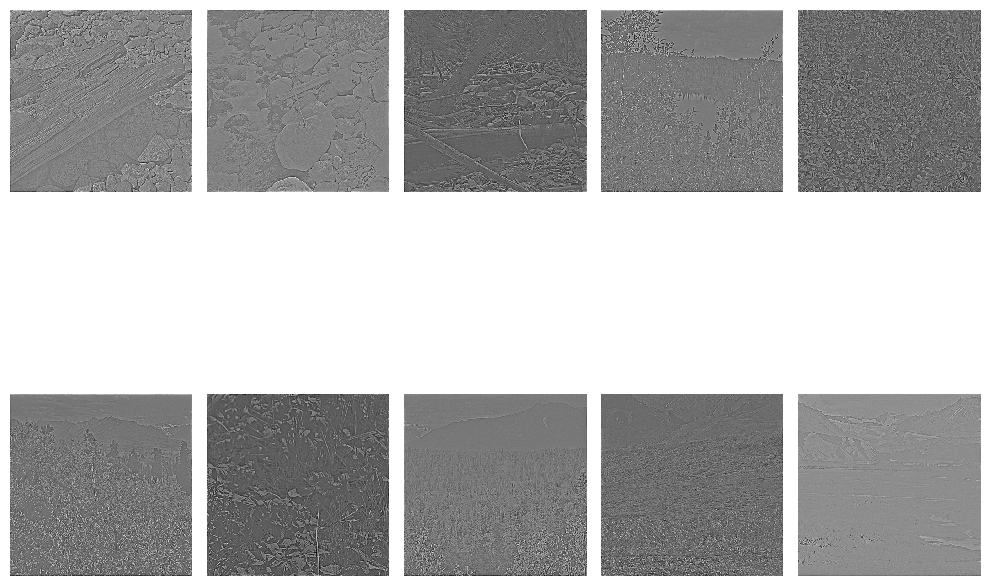

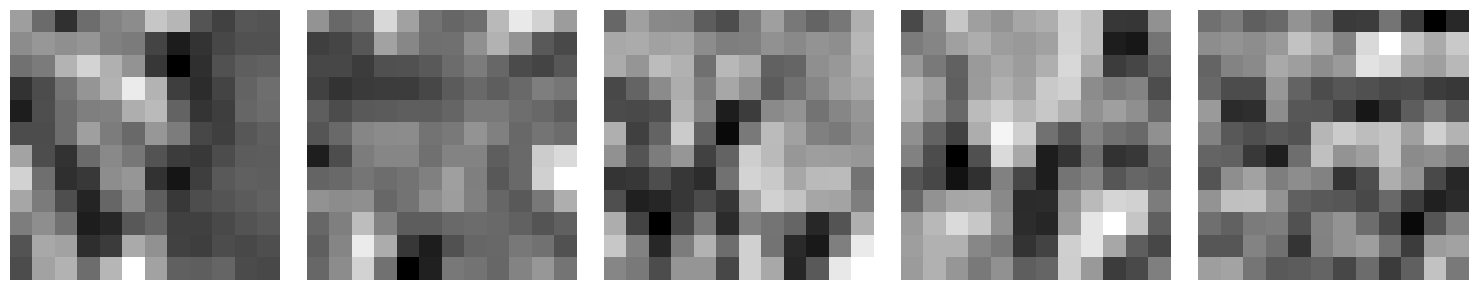

In [8]:
# 显示所有图像
fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[:, :, i], cmap='gray', interpolation='nearest')
    ax.axis('off')
plt.tight_layout()
plt.show()

# 显示随机补丁
patches = extract_random_patches(images)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(patches[i], cmap='gray', interpolation='nearest')
    ax.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 20000/20000 [02:45<00:00, 120.67it/s]


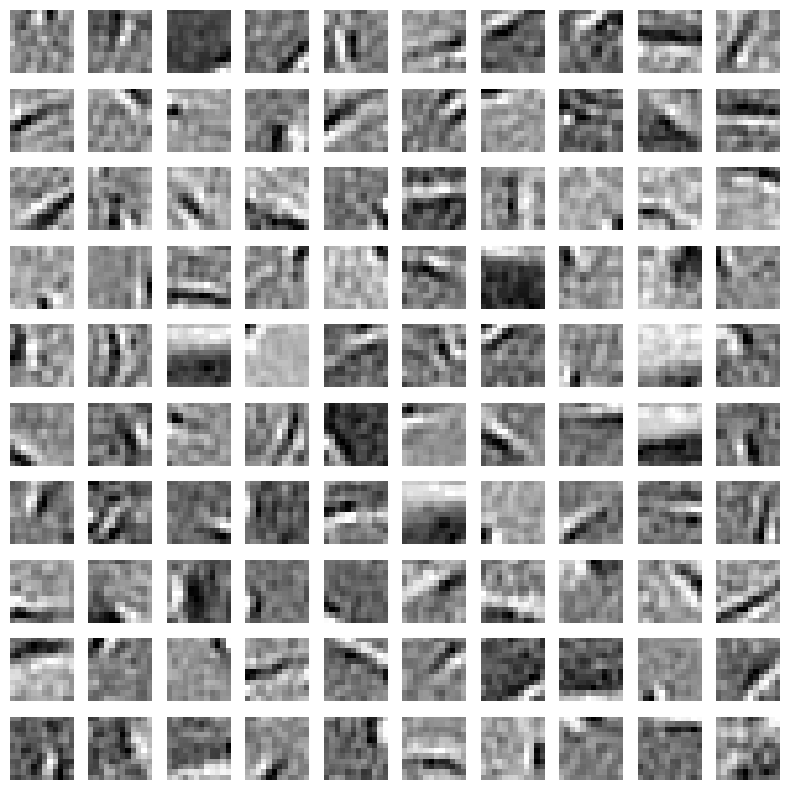

In [9]:
# 训练循环
echos = 20000
psi = np.random.randn(144, 100)  # 初始化字典矩阵

for i in tqdm(range(echos)):
    x_map = None
    x = np.zeros(100)
    lamb = np.ones(100)
    lamb_mat = np.diag(lamb)
    
    # 提取并预处理补丁
    Y = extract_random_patch_from_image1(images)
    Y = Y.flatten()
    Y = (Y - np.mean(Y)) / np.std(Y)
    
    # E-step (3次迭代)
    for j in range(3):
        x, x_map, lamb, lamb_mat, covariance = e_step(x, lamb, lamb_mat, Y, psi)
    
    # M-step
    psi = m_step(x_map, Y, covariance, psi)

# 显示学习到的基向量
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
for k, ax in enumerate(axes.flat):
    basis = psi[:, k].reshape(12, 12)
    ax.imshow(basis, cmap='gray', interpolation='nearest')
    ax.axis('off')

plt.tight_layout()
plt.show()